<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_going-deeper/01_nlp/GD-04/%5BGD-04%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 04 : 뉴스 카테고리 다중분류**

- **Vocabulary Size를 변경해서 시도해보기**  


- 분류 모델의 accuracy가 기준 이상 높게 나왔는가?  
    3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.  
    

- 분류 모델의 F1 score가 기준 이상 높게 나왔는가?  
Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.  
    
    
- 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?  
동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.  

---

## **1. 데이터 준비**

### **1-1. 라이브러리 Import**

In [ ]:
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport

from tensorflow import keras
from tensorflow.keras.datasets import reuters

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### **1-2. 데이터 Import**

#### 전체의 80%를 훈련 데이터, 20%를 테스트 데이터로 사용

- 다양한 비교를 위해 5개의 num_word로 분류 (전체 / 10,000 / 5,000 / 3,000 / 1,000)

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words = None, test_split = 0.2)
(x_train_1M, y_train_1M), (x_test_1M, y_test_1M) = reuters.load_data(num_words = 10000, test_split = 0.2)
(x_train_5T, y_train_5T), (x_test_5T, y_test_5T) = reuters.load_data(num_words = 5000, test_split = 0.2)
(x_train_3T, y_train_3T), (x_test_3T, y_test_3T) = reuters.load_data(num_words = 3000, test_split = 0.2)
(x_train_1T, y_train_1T), (x_test_1T, y_test_1T) = reuters.load_data(num_words = 1000, test_split = 0.2)

### **1-3. 클래스 확인**

- 레이블: test, train 각 3개 (정수 형태)

In [ ]:
print(y_train[0])
print(y_test[0])

3
3


- 전체 클래스 수: 46개

In [ ]:
num_classes = max(y_train) + 1
print('전체 클래스 수: {}'.format(num_classes))

전체 클래스 수: 46


- 클래스 분포 확인: 3,4의 분포가 월등히 많고, 1, 11, 16, 19번의 분포가 약 400개 이상의 분포를 보임

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts = True)

for index, value in enumerate(counts_elements):
    print(f'({index}){value}', end = ', ')

(0)55, (1)432, (2)74, (3)3159, (4)1949, (5)17, (6)48, (7)16, (8)139, (9)101, (10)124, (11)390, (12)49, (13)172, (14)26, (15)20, (16)444, (17)39, (18)66, (19)549, (20)269, (21)100, (22)15, (23)41, (24)62, (25)92, (26)24, (27)15, (28)48, (29)19, (30)45, (31)39, (32)32, (33)11, (34)50, (35)10, (36)49, (37)19, (38)19, (39)24, (40)36, (41)30, (42)13, (43)21, (44)12, (45)18, 

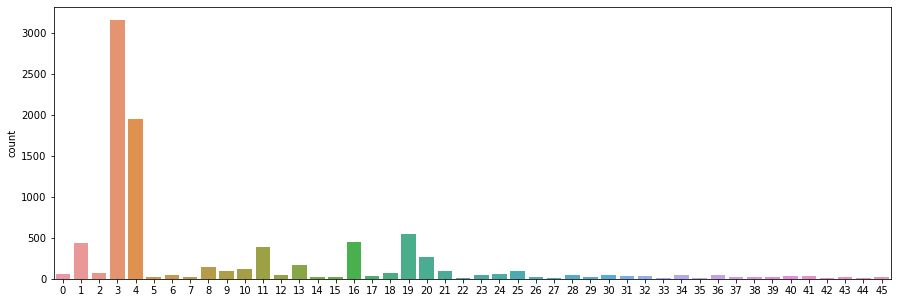

In [ ]:
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(15,5)
sns.countplot(x = y_train)
plt.show()

### **1-4. 데이터 확인**

#### 데이터 수 확인

- 전체 샘플 수: 11,228개 / train 샘플 수: 8,982개 / test 샘플 수: 2,246개

In [ ]:
print('전체 데이터 수: {}'.format(len(x_train) + len(x_test)))
print('train 데이터 수: {}'.format(len(x_train)))
print('test 데이터 수: {}'.format(len(x_test)))

전체 데이터 수: 11228
train 데이터 수: 8982
test 데이터 수: 2246


#### 데이터 길이 분포 확인

- train 데이터 기준 확인   
최소 길이:13 / 최대 길이:2376 / 평균 길이:145.5

train 데이터 최소 길이:13
train 데이터 최대 길이:2376
train 데이터 평균 길이:145.5398574927633


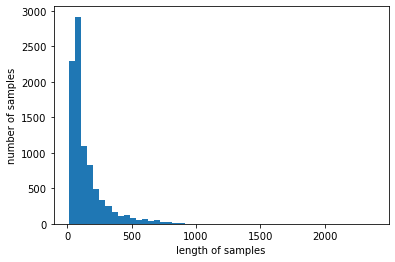

In [ ]:
print('train 데이터 최소 길이:{}'.format(min(len(l) for l in x_train)))
print('train 데이터 최대 길이:{}'.format(max(len(l) for l in x_train)))
print('train 데이터 평균 길이:{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- test 데이터 기준 확인   
최소 길이:2 / 최대 길이:1032 / 평균 길이:147.6

test 데이터 최소 길이:2
test 데이터 최대 길이:1032
test 데이터 평균 길이:147.66117542297417


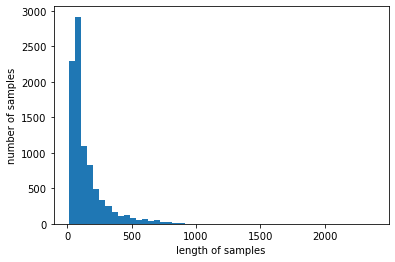

In [ ]:
print('test 데이터 최소 길이:{}'.format(min(len(l) for l in x_test)))
print('test 데이터 최대 길이:{}'.format(max(len(l) for l in x_test)))
print('test 데이터 평균 길이:{}'.format(sum(map(len, x_test))/len(x_test)))

plt.hist([len(s) for s in x_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### **1-5. 데이터 변환**

#### 데이터 형태 확인

- 기본적으로 빈도수가 높은 순서대로 낮은 정수가 맵핑된 전처리 데이터 제공

In [ ]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

#### 텍스트 데이터 변환

- 정수 시퀀스로 변환된 데이터 텍스트 데이터로 변환

In [ ]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

#### 단어 맵핑

- 단어를 맵핑 한 정수에 -3을 한 정수를 입력해 놓았으므로 단어 + 3이 원래 고유 숫자

In [ ]:
word_index['the']

1

In [ ]:
index_to_word = { index + 3 : word for word, index in word_index.items() }

In [ ]:
print(index_to_word[4])

the


- 로이터 뉴스 데이터는 0-2번을 자연어 처리를 위한 토큰을 위해 번호 맵핑 필요  

    0: \<pad>, 1: \<sos>, 2: \<unk>

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

#### 단어 맵핑 처리

- 맵핑 처리 함수

In [ ]:
def mapping_text(data):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

- num_word에 따른 각 데이터 맵핑 처리

In [ ]:
x_train, x_test = mapping_text(x_train), mapping_text(x_test)
x_train_1M, x_test_1M = mapping_text(x_train_1M), mapping_text(x_test_1M)
x_train_5T, x_test_5T = mapping_text(x_train_5T), mapping_text(x_test_5T)
x_train_3T, x_test_3T = mapping_text(x_train_3T), mapping_text(x_test_3T) 
x_train_1T, x_test_1T = mapping_text(x_train_1T), mapping_text(x_test_1T)

#### 맵핑 처리 완료 텍스트 확인

In [ ]:
def mapping_text_print(train, test):
    print('\n', train)
    print('\n', test)
    print('-' * 138)

- 이미 전처리가 어느정도 진행되었기 때문에 자연스러운 문맥이 아님   

    맵핑이 진행되지 않은 경우 \<unk>로 출력됨  
    num_words 수가 적어질수록 \<unk>의 수가 많이 출력되는 것을 볼 수 있음

In [ ]:
print('<전체 num_words 사용>')
mapping_text_print(x_train[0], x_test[0])

print('<10,000개의 num_words 사용>')
mapping_text_print(x_train_1M[0], x_test_1M[0])

print('<5,000개의 num_words 사용>')
mapping_text_print(x_train_5T[0], x_test_5T[0])

print('<3,000개의 num_words 사용>')
mapping_text_print(x_train_3T[0], x_test_3T[0])

print('<1,000개의 num_words 사용>')
mapping_text_print(x_train_1T[0], x_test_1T[0])

<전체 num_words 사용>

 <sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3

 <sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave

### 1-6. 벡터화

#### DTM / TF-IDF Matrix 

- DTM 벡터화 및 TF-IDF Matrix 벡터화 함수

In [ ]:
dtm_vector = CountVectorizer()
tfidf_vector = TfidfTransformer()

def vector(train, test):
    dtm_x_train = dtm_vector.fit_transform(train)
    tfidf_x_train = tfidf_vector.fit_transform(dtm_x_train)
    
    dtm_x_test = dtm_vector.transform(test)
    tfidf_x_test = tfidf_vector.transform(dtm_x_test)
    
    print('\n', tfidf_x_train.shape, '/', tfidf_x_test.shape)
    print('-' * 40)
    
    return (tfidf_x_train, tfidf_x_test)

- 벡터 형태 확인    

    <전체 num_words 사용>   
    train 행: 8,982개 / train 열: 26,506개 / test 행: 2,246개 / test 열: 26,506개  

    <10,000개 num_words 사용>  
    train 행: 8,982개 / train 열: 9,670개 / test 행: 2,246개 / test 열: 9,670개   

    <5,000개 num_words 사용>  
    train 행: 8,982개 / train 열: 4,867개 / test 행: 2,246개 / test 열: 4,867개  

    <3,000개 num_words 사용>  
    train 행: 8,982개 / train 열: 2,919개 / test 행: 2,246개 / test 열: 2,919개    
    
    <1,000개 num_words 사용>  
    train 행: 8,982개 / train 열: 969개 / test 행: 2,246개 / test 열: 969개  

In [ ]:
print('<vector_x_train / vector_x_test>')
vector_x_train, vector_x_test = vector(x_train, x_test)
print('<vector_x_train_1M / vector_x_test_1M>')
vector_x_train_1M, vector_x_test_1M = vector(x_train_1M, x_test_1M)
print('<vector_x_train_5T/ vector_x_test_5T>')
vector_x_train_5T, vector_x_test_5T = vector(x_train_5T, x_test_5T)
print('<vector_x_train_3T / vector_x_test_3T>')
vector_x_train_3T, vector_x_test_3T = vector(x_train_3T, x_test_3T) 
print('<vector_x_train_1T / vector_x_test_1T>')
vector_x_train_1T, vector_x_test_1T = vector(x_train_1T, x_test_1T)

<vector_x_train / vector_x_test>

 (8982, 26506) / (2246, 26506)
----------------------------------------
<vector_x_train_1M / vector_x_test_1M>

 (8982, 9670) / (2246, 9670)
----------------------------------------
<vector_x_train_5T/ vector_x_test_5T>

 (8982, 4867) / (2246, 4867)
----------------------------------------
<vector_x_train_3T / vector_x_test_3T>

 (8982, 2919) / (2246, 2919)
----------------------------------------
<vector_x_train_1T / vector_x_test_1T>

 (8982, 969) / (2246, 969)
----------------------------------------


## 2. 머신러닝 모델을 사용한 학습 및 평가

#### 머신러닝 모델 학습 및 성능 평가 함수

- accuracy, F1 Score(weighted / micro) 3가지 성능 지표로 성능 확인

In [ ]:
def ml_model_train(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
 
    accuracy = accuracy_score(y_test, predict)
    f1_weight = f1_score(y_test, predict, average = "weighted")
    f1_micro = f1_score(y_test, predict, average = "micro")
    return (accuracy, f1_weight, f1_micro)

#### 모델 성능 평가 출력 함수

In [ ]:
def ml_model_result(accuracy, f1_weight, f1_micro, model_name):
    print(f"\n<{model_name}>\n")
    print("Accuracy:", round(accuracy, 5))
    print("F1-Score(Weight):", round(accuracy, 5))
    print("F1-Score(Micro):", round(accuracy, 5), '\n')
    print('-' * 60)

### 2-1. 나이브 베이즈 분류기 (Multinomial Naive Bayes Classifier)

In [ ]:
NB_accuracy, NB_f1_weight, NB_f1_micro =  ml_model_train(MultinomialNB(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(NB_accuracy, NB_f1_weight, NB_f1_micro, "나이브 베이즈: 전체 num_words 사용")

NB_1M_accuracy, NB_1M_f1_weight, NB_1M_f1_micro =  ml_model_train(MultinomialNB(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(NB_1M_accuracy, NB_1M_f1_weight, NB_1M_f1_micro, "나이브 베이즈: 10,000개의 num_words 사용")

NB_5T_accuracy, NB_5T_f1_weight, NB_5T_f1_micro =  ml_model_train(MultinomialNB(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(NB_5T_accuracy, NB_5T_f1_weight, NB_5T_f1_micro, "나이브 베이즈: 5,000개의 num_words 사용")

NB_3T_accuracy, NB_3T_f1_weight, NB_3T_f1_micro =  ml_model_train(MultinomialNB(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(NB_3T_accuracy, NB_3T_f1_weight, NB_3T_f1_micro, "나이브 베이즈: 3,000개의 num_words 사용")

NB_1T_accuracy, NB_1T_f1_weight, NB_1T_f1_micro =  ml_model_train(MultinomialNB(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(NB_1T_accuracy, NB_1T_f1_weight, NB_1T_f1_micro, "나이브 베이즈: 1,000개의 num_words 사용")


<나이브 베이즈: 전체 num_words 사용>

Accuracy: 0.59973
F1-Score(Weight): 0.59973
F1-Score(Micro): 0.59973 

------------------------------------------------------------

<나이브 베이즈: 10,000개의 num_words 사용>

Accuracy: 0.65672
F1-Score(Weight): 0.65672
F1-Score(Micro): 0.65672 

------------------------------------------------------------

<나이브 베이즈: 5,000개의 num_words 사용>

Accuracy: 0.6732
F1-Score(Weight): 0.6732
F1-Score(Micro): 0.6732 

------------------------------------------------------------

<나이브 베이즈: 3,000개의 num_words 사용>

Accuracy: 0.68744
F1-Score(Weight): 0.68744
F1-Score(Micro): 0.68744 

------------------------------------------------------------

<나이브 베이즈: 1,000개의 num_words 사용>

Accuracy: 0.68566
F1-Score(Weight): 0.68566
F1-Score(Micro): 0.68566 

------------------------------------------------------------


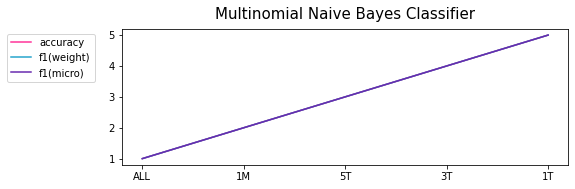

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-2. Complement Naive Bayes Classifier (CNB)

In [ ]:
CNB_accuracy, CNB_f1_weight, CNB_f1_micro =  ml_model_train(ComplementNB(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(CNB_accuracy, CNB_f1_weight, CNB_f1_micro, "컴플리먼트 나이브 베이즈: 전체 num_words 사용")

CNB_1M_accuracy, CNB_1M_f1_weight, CNB_1M_f1_micro =  ml_model_train(ComplementNB(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(CNB_1M_accuracy, CNB_1M_f1_weight, CNB_1M_f1_micro, "컴플리먼트 나이브 베이즈: 10,000개의 num_words 사용")

CNB_5T_accuracy, CNB_5T_f1_weight, CNB_5T_f1_micro =  ml_model_train(ComplementNB(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(CNB_5T_accuracy, CNB_5T_f1_weight, CNB_5T_f1_micro, "컴플리먼트 나이브 베이즈: 5,000개의 num_words 사용")

CNB_3T_accuracy, CNB_3T_f1_weight, CNB_3T_f1_micro =  ml_model_train(ComplementNB(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(CNB_3T_accuracy, CNB_3T_f1_weight, CNB_3T_f1_micro, "컴플리먼트 나이브 베이즈: 3,000개의 num_words 사용")

CNB_1T_accuracy, CNB_1T_f1_weight, CNB_1T_f1_micro =  ml_model_train(ComplementNB(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(CNB_1T_accuracy, CNB_1T_f1_weight, CNB_1T_f1_micro, "컴플리먼트 나이브 베이즈: 1,000개의 num_words 사용")


<컴플리먼트 나이브 베이즈: 전체 num_words 사용>

Accuracy: 0.76492
F1-Score(Weight): 0.76492
F1-Score(Micro): 0.76492 

------------------------------------------------------------

<컴플리먼트 나이브 베이즈: 10,000개의 num_words 사용>

Accuracy: 0.7707
F1-Score(Weight): 0.7707
F1-Score(Micro): 0.7707 

------------------------------------------------------------

<컴플리먼트 나이브 베이즈: 5,000개의 num_words 사용>

Accuracy: 0.7707
F1-Score(Weight): 0.7707
F1-Score(Micro): 0.7707 

------------------------------------------------------------

<컴플리먼트 나이브 베이즈: 3,000개의 num_words 사용>

Accuracy: 0.76447
F1-Score(Weight): 0.76447
F1-Score(Micro): 0.76447 

------------------------------------------------------------

<컴플리먼트 나이브 베이즈: 1,000개의 num_words 사용>

Accuracy: 0.73464
F1-Score(Weight): 0.73464
F1-Score(Micro): 0.73464 

------------------------------------------------------------


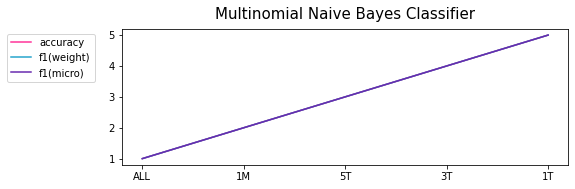

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-3. 로지스틱 회귀 (Logistic Regression)

In [ ]:
def LR_model():
    return LogisticRegression(C = 10000, penalty = 'l2', max_iter = 5000)

In [ ]:
LR_accuracy, LR_f1_weight, LR_f1_micro =  ml_model_train(LR_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(LR_accuracy, LR_f1_weight, LR_f1_micro, "로지스틱 회귀: 전체 num_words 사용")

LR_1M_accuracy, LR_1M_f1_weight, LR_1M_f1_micro =  ml_model_train(LR_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(LR_1M_accuracy, LR_1M_f1_weight, LR_1M_f1_micro, "로지스틱 회귀: 10,000개의 num_words 사용")

LR_5T_accuracy, LR_5T_f1_weight, LR_5T_f1_micro =  ml_model_train(LR_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(LR_5T_accuracy, LR_5T_f1_weight, LR_5T_f1_micro, "로지스틱 회귀: 5,000개의 num_words 사용")

LR_3T_accuracy, LR_3T_f1_weight, LR_3T_f1_micro =  ml_model_train(LR_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(LR_3T_accuracy, LR_3T_f1_weight, LR_3T_f1_micro, "로지스틱 회귀: 3,000개의 num_words 사용")

LR_1T_accuracy, LR_1T_f1_weight, LR_1T_f1_micro =  ml_model_train(LR_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(LR_1T_accuracy, LR_1T_f1_weight, LR_1T_f1_micro, "로지스틱 회귀: 1,000개의 num_words 사용")


<로지스틱 회귀: 전체 num_words 사용>

Accuracy: 0.81701
F1-Score(Weight): 0.81701
F1-Score(Micro): 0.81701 

------------------------------------------------------------

<로지스틱 회귀: 10,000개의 num_words 사용>

Accuracy: 0.81077
F1-Score(Weight): 0.81077
F1-Score(Micro): 0.81077 

------------------------------------------------------------

<로지스틱 회귀: 5,000개의 num_words 사용>

Accuracy: 0.80276
F1-Score(Weight): 0.80276
F1-Score(Micro): 0.80276 

------------------------------------------------------------

<로지스틱 회귀: 3,000개의 num_words 사용>

Accuracy: 0.78807
F1-Score(Weight): 0.78807
F1-Score(Micro): 0.78807 

------------------------------------------------------------

<로지스틱 회귀: 1,000개의 num_words 사용>

Accuracy: 0.73865
F1-Score(Weight): 0.73865
F1-Score(Micro): 0.73865 

------------------------------------------------------------


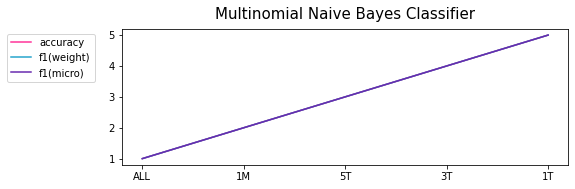

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-4. 선형 서포트 벡터 머신 (Linear Support Vector Machine)

In [ ]:
def SVM_model():
    return LinearSVC(C = 1000, penalty = 'l1', max_iter = 5000, dual = False)

In [ ]:
SVM_accuracy, SVM_f1_weight, SVM_f1_micro =  ml_model_train(SVM_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(SVM_accuracy, SVM_f1_weight, SVM_f1_micro, "선형 서포트 벡터 머신: 전체 num_words 사용")

SVM_1M_accuracy, SVM_1M_f1_weight, SVM_1M_f1_micro =  ml_model_train(SVM_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(SVM_1M_accuracy, SVM_1M_f1_weight, SVM_1M_f1_micro, "선형 서포트 벡터 머신: 10,000개의 num_words 사용")

SVM_5T_accuracy, SVM_5T_f1_weight, SVM_5T_f1_micro =  ml_model_train(SVM_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(SVM_5T_accuracy, SVM_5T_f1_weight, SVM_5T_f1_micro, "선형 서포트 벡터 머신: 5,000개의 num_words 사용")

SVM_3T_accuracy, SVM_3T_f1_weight, SVM_3T_f1_micro =  ml_model_train(SVM_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(SVM_3T_accuracy, SVM_3T_f1_weight, SVM_3T_f1_micro, "선형 서포트 벡터 머신: 3,000개의 num_words 사용")

SVM_1T_accuracy, SVM_1T_f1_weight, SVM_1T_f1_micro =  ml_model_train(SVM_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(SVM_1T_accuracy, SVM_1T_f1_weight, SVM_1T_f1_micro, "선형 서포트 벡터 머신: 1,000개의 num_words 사용")


<선형 서포트 벡터 머신: 전체 num_words 사용>

Accuracy: 0.78807
F1-Score(Weight): 0.78807
F1-Score(Micro): 0.78807 

------------------------------------------------------------

<선형 서포트 벡터 머신: 10,000개의 num_words 사용>

Accuracy: 0.78139
F1-Score(Weight): 0.78139
F1-Score(Micro): 0.78139 

------------------------------------------------------------

<선형 서포트 벡터 머신: 5,000개의 num_words 사용>

Accuracy: 0.77159
F1-Score(Weight): 0.77159
F1-Score(Micro): 0.77159 

------------------------------------------------------------

<선형 서포트 벡터 머신: 3,000개의 num_words 사용>

Accuracy: 0.75378
F1-Score(Weight): 0.75378
F1-Score(Micro): 0.75378 

------------------------------------------------------------

<선형 서포트 벡터 머신: 1,000개의 num_words 사용>

Accuracy: 0.7195
F1-Score(Weight): 0.7195
F1-Score(Micro): 0.7195 

------------------------------------------------------------


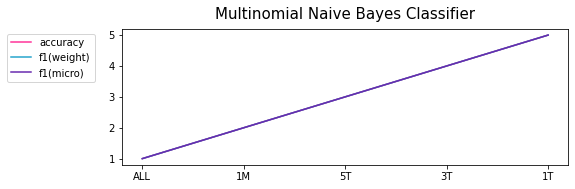

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-5. 결정 트리 (Decision Tree)

In [ ]:
def DT_model():
    return DecisionTreeClassifier(max_depth = 10, random_state = 0)

In [ ]:
DT_accuracy, DT_f1_weight, DT_f1_micro =  ml_model_train(DT_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(DT_accuracy, DT_f1_weight, DT_f1_micro, "결정 트리: 전체 num_words 사용")

DT_1M_accuracy, DT_1M_f1_weight, DT_1M_f1_micro =  ml_model_train(DT_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(DT_1M_accuracy, DT_1M_f1_weight, DT_1M_f1_micro, "결정 트리: 10,000개의 num_words 사용")

DT_5T_accuracy, DT_5T_f1_weight, DT_5T_f1_micro =  ml_model_train(DT_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(DT_5T_accuracy, DT_5T_f1_weight, DT_5T_f1_micro, "결정 트리: 5,000개의 num_words 사용")

DT_3T_accuracy, DT_3T_f1_weight, DT_3T_f1_micro =  ml_model_train(DT_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(DT_3T_accuracy, DT_3T_f1_weight, DT_3T_f1_micro, "결정 트리: 3,000개의 num_words 사용")

DT_1T_accuracy, DT_1T_f1_weight, DT_1T_f1_micro =  ml_model_train(DT_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(DT_1T_accuracy, DT_1T_f1_weight, DT_1T_f1_micro, "결정 트리: 1,000개의 num_words 사용")


<결정 트리: 전체 num_words 사용>

Accuracy: 0.6211
F1-Score(Weight): 0.6211
F1-Score(Micro): 0.6211 

------------------------------------------------------------

<결정 트리: 10,000개의 num_words 사용>

Accuracy: 0.62021
F1-Score(Weight): 0.62021
F1-Score(Micro): 0.62021 

------------------------------------------------------------

<결정 트리: 5,000개의 num_words 사용>

Accuracy: 0.61799
F1-Score(Weight): 0.61799
F1-Score(Micro): 0.61799 

------------------------------------------------------------

<결정 트리: 3,000개의 num_words 사용>

Accuracy: 0.626
F1-Score(Weight): 0.626
F1-Score(Micro): 0.626 

------------------------------------------------------------

<결정 트리: 1,000개의 num_words 사용>

Accuracy: 0.61799
F1-Score(Weight): 0.61799
F1-Score(Micro): 0.61799 

------------------------------------------------------------


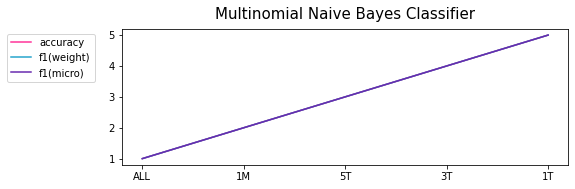

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-6. 랜덤 포레스트 (Random Forest)

In [ ]:
def RF_model():
    return RandomForestClassifier(n_estimators = 5, random_state = 0)

In [ ]:
RF_accuracy, RF_f1_weight, RF_f1_micro =  ml_model_train(RF_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(RF_accuracy, RF_f1_weight, RF_f1_micro, "랜덤 포레스트: 전체 num_words 사용")

RF_1M_accuracy, RF_1M_f1_weight, RF_1M_f1_micro =  ml_model_train(RF_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(RF_1M_accuracy, RF_1M_f1_weight, RF_1M_f1_micro, "랜덤 포레스트: 10,000개의 num_words 사용")

RF_5T_accuracy, RF_5T_f1_weight, RF_5T_f1_micro =  ml_model_train(RF_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(RF_5T_accuracy, RF_5T_f1_weight, RF_5T_f1_micro, "랜덤 포레스트: 5,000개의 num_words 사용")

RF_3T_accuracy, RF_3T_f1_weight, RF_3T_f1_micro =  ml_model_train(RF_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(RF_3T_accuracy, RF_3T_f1_weight, RF_3T_f1_micro, "랜덤 포레스트: 3,000개의 num_words 사용")

RF_1T_accuracy, RF_1T_f1_weight, RF_1T_f1_micro =  ml_model_train(RF_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(RF_1T_accuracy, RF_1T_f1_weight, RF_1T_f1_micro, "랜덤 포레스트: 1,000개의 num_words 사용")


<랜덤 포레스트: 전체 num_words 사용>

Accuracy: 0.6545
F1-Score(Weight): 0.6545
F1-Score(Micro): 0.6545 

------------------------------------------------------------

<랜덤 포레스트: 10,000개의 num_words 사용>

Accuracy: 0.67409
F1-Score(Weight): 0.67409
F1-Score(Micro): 0.67409 

------------------------------------------------------------

<랜덤 포레스트: 5,000개의 num_words 사용>

Accuracy: 0.70125
F1-Score(Weight): 0.70125
F1-Score(Micro): 0.70125 

------------------------------------------------------------

<랜덤 포레스트: 3,000개의 num_words 사용>

Accuracy: 0.68566
F1-Score(Weight): 0.68566
F1-Score(Micro): 0.68566 

------------------------------------------------------------

<랜덤 포레스트: 1,000개의 num_words 사용>

Accuracy: 0.70748
F1-Score(Weight): 0.70748
F1-Score(Micro): 0.70748 

------------------------------------------------------------


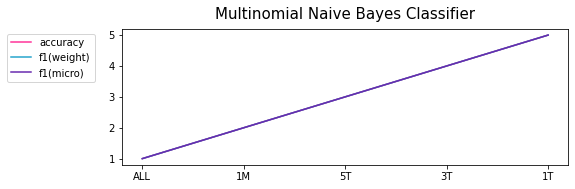

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-7. 그래디언트 부스팅 트리 (GradientBoostingClassifier)

In [ ]:
def GBC_model():
    return GradientBoostingClassifier(random_state = 0, learning_rate = 0.01)

In [ ]:
GBC_accuracy, GBC_f1_weight, GBC_f1_micro =  ml_model_train(GBC_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(GBC_accuracy, GBC_f1_weight, GBC_f1_micro, "그래디언트 부스팅 트리: 전체 num_words 사용")

GBC_1M_accuracy, GBC_1M_f1_weight, GBC_1M_f1_micro =  ml_model_train(GBC_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(GBC_1M_accuracy, GBC_1M_f1_weight, GBC_1M_f1_micro, "그래디언트 부스팅 트리: 10,000개의 num_words 사용")

GBC_5T_accuracy, GBC_5T_f1_weight, GBC_5T_f1_micro =  ml_model_train(GBC_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(GBC_5T_accuracy, GBC_5T_f1_weight, GBC_5T_f1_micro, "그래디언트 부스팅 트리: 5,000개의 num_words 사용")

GBC_3T_accuracy, GBC_3T_f1_weight, GBC_3T_f1_micro =  ml_model_train(GBC_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(GBC_3T_accuracy, GBC_3T_f1_weight, GBC_3T_f1_micro, "그래디언트 부스팅 트리: 3,000개의 num_words 사용")

GBC_1T_accuracy, GBC_1T_f1_weight, GBC_1T_f1_micro =  ml_model_train(GBC_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(GBC_1T_accuracy, GBC_1T_f1_weight, GBC_1T_f1_micro, "그래디언트 부스팅 트리: 1,000개의 num_words 사용")


<그래디언트 부스팅 트리: 전체 num_words 사용>

Accuracy: 0.7618
F1-Score(Weight): 0.7618
F1-Score(Micro): 0.7618 

------------------------------------------------------------

<그래디언트 부스팅 트리: 10,000개의 num_words 사용>

Accuracy: 0.75735
F1-Score(Weight): 0.75735
F1-Score(Micro): 0.75735 

------------------------------------------------------------

<그래디언트 부스팅 트리: 5,000개의 num_words 사용>

Accuracy: 0.76224
F1-Score(Weight): 0.76224
F1-Score(Micro): 0.76224 

------------------------------------------------------------

<그래디언트 부스팅 트리: 3,000개의 num_words 사용>

Accuracy: 0.75601
F1-Score(Weight): 0.75601
F1-Score(Micro): 0.75601 

------------------------------------------------------------

<그래디언트 부스팅 트리: 1,000개의 num_words 사용>

Accuracy: 0.74176
F1-Score(Weight): 0.74176
F1-Score(Micro): 0.74176 

------------------------------------------------------------


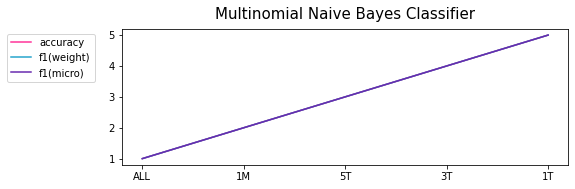

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 2-8. 보팅 (Voting)

In [ ]:
def voting_model():
    voting_classifier = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(C = 10000, penalty = 'l2')),
            ('cb', ComplementNB())
        ], voting='soft', n_jobs =- 1
    )
    return voting_classifier

In [ ]:
voting_accuracy, voting_f1_weight, voting_f1_micro =  ml_model_train(voting_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(voting_accuracy, voting_f1_weight, voting_f1_micro, "보팅: 전체 num_words 사용")

voting_1M_accuracy, voting_1M_f1_weight, voting_1M_f1_micro =  ml_model_train(voting_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(voting_1M_accuracy, voting_1M_f1_weight, voting_1M_f1_micro, "보팅: 10,000개의 num_words 사용")

voting_5T_accuracy, voting_5T_f1_weight, voting_5T_f1_micro =  ml_model_train(voting_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(voting_5T_accuracy, voting_5T_f1_weight, voting_5T_f1_micro, "보팅: 5,000개의 num_words 사용")

voting_3T_accuracy, voting_3T_f1_weight, voting_3T_f1_micro =  ml_model_train(voting_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(voting_3T_accuracy, voting_3T_f1_weight, voting_3T_f1_micro, "보팅: 3,000개의 num_words 사용")

voting_1T_accuracy, voting_1T_f1_weight, voting_1T_f1_micro =  ml_model_train(voting_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(voting_1T_accuracy, voting_1T_f1_weight, voting_1T_f1_micro, "보팅: 1,000개의 num_words 사용")


<보팅: 전체 num_words 사용>

Accuracy: 0.81567
F1-Score(Weight): 0.81567
F1-Score(Micro): 0.81567 

------------------------------------------------------------

<보팅: 10,000개의 num_words 사용>

Accuracy: 0.81122
F1-Score(Weight): 0.81122
F1-Score(Micro): 0.81122 

------------------------------------------------------------

<보팅: 5,000개의 num_words 사용>

Accuracy: 0.80944
F1-Score(Weight): 0.80944
F1-Score(Micro): 0.80944 

------------------------------------------------------------

<보팅: 3,000개의 num_words 사용>

Accuracy: 0.80053
F1-Score(Weight): 0.80053
F1-Score(Micro): 0.80053 

------------------------------------------------------------

<보팅: 1,000개의 num_words 사용>

Accuracy: 0.78406
F1-Score(Weight): 0.78406
F1-Score(Micro): 0.78406 

------------------------------------------------------------


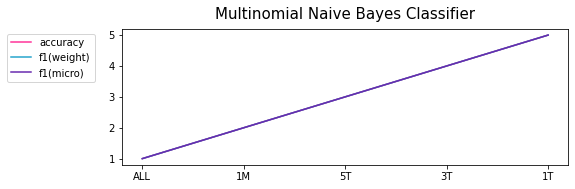

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

## 3. 딥러닝 모델을 사용한 학습 및 평가

In [ ]:
vector_x_train_array = vector_x_train.toarray()
vector_x_train_dense = vector_x_train.todense()

In [ ]:
vector_x_test_array = vector_x_test.toarray()
vector_x_test_dense = vector_x_test.todense()

In [ ]:
def rnn(num_layer = 8):

    model_dense = keras.Sequential()
    model_dense.add(keras.layers.Dense(num_layer * 4, activation = 'gelu', input_shape = (vector_x_train_dense.shape[1],)))  
    model_dense.add(keras.layers.Dense(num_layer * 4, activation = 'gelu')) 
    model_dense.add(keras.layers.Dense(num_layer * 8, activation = 'gelu')) 
    model_dense.add(keras.layers.Dense(num_layer * 16, activation = 'gelu'))  
    model_dense.add(keras.layers.Dense(num_classes, activation = 'softmax'))  

    model_dense.summary()
    
    early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    model_dense.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 20
    batch_size = 128

    history_dense = model_dense.fit(vector_x_train_dense, y_train, epochs = epochs, batch_size = batch_size, callbacks = [early], validation_split = 0.2, verbose = 1)    
    results = model_dense.evaluate(vector_x_test_dense,  y_test, verbose = 2)
    print(results)
    
    return history_dense, model_dense

In [ ]:
history_dense, model_dense = rnn()

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

## 4. 전체 학습 결과 평가 비교

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

In [ ]:
plt.figure(figsize = (8, 2.5))
plt.title('Multinomial Naive Bayes Classifier', pad = 10, size = 15)
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#ff3399', label = 'accuracy')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#25a4cd', label = 'f1(weight)')
plt.plot(['ALL', '1M', '5T', '3T', '1T'], [1, 2, 3, 4, 5], color='#682aae', label = 'f1(micro)')
plt.legend(bbox_to_anchor = (-0.05, 1))

### 표 그려서 비교

---

## 5. 회고

벡터화, 모델 등 동일한 작업을 진행하는 경우가 많아 학습 함수를 만들고 싶었으나 혼자서는 제대로 구동되게 만들지 못해서 아래의 페이지를 참고했다. 오히려 이번 학습의 경우에는 이론 부분에서 수식 부분에서 많은 애를 먹었는데, 오히려 실습 부분에서는 크게 오류 없이 잘 진행되어서 내가 직접 코드를 진행해보는 시간이 되었던 것 같다. 이번에는 동일한 조건을 가진 경우를 다양한 모델으로 비교하는 시간이었기 때문에 함수를 사용하는 것이 큰 도움이 되겠다는 판단이 들어 함수를 제작하려는 시도를 많이 해보려 노력했는데, 아직 코딩 실력이 부족한 관계로 함수에 대한 이해가 부족한 것 같다. 함수를 사용하면 확실히 코드가 깔끔하고 더 사용하기 좋기 때문에 함수를 잘 짜는 것이 중요하다는 생각이 들어 파이썬 공부를 좀 더 해야겠다는 생각이 들었다.